# ORTHOGONAL POLYNOMIAL DENSITY ESTIMATION
## Preliminaries
### Imports

In [1]:
import matplotlib.pyplot as plt
import seaborn as sbn
import numpy as np
import numpy.polynomial.legendre as npl

from scipy.optimize import minimize

### Notebook settings

In [2]:
%matplotlib notebook
sbn.set_style('white')

legend_params = {'loc': 'best',
                 'frameon': True, 
                 'fancybox': True, 
                 'framealpha': 0.7}

## Create Synthetic Data

<IPython.core.display.Javascript object>


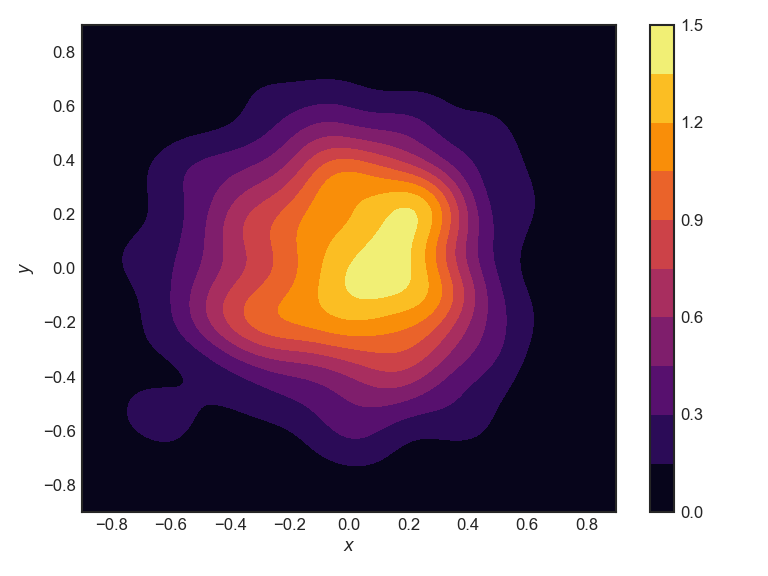

In [65]:
N = 400

x, y = np.random.multivariate_normal((0,0), ((0.1,0), (0,0.1)), size=N).T

fig, ax = plt.subplots()
sbn.kdeplot(x, y, shade=True, gridsize=250, bw=(0.1, 0.1), ax=ax, cmap='inferno', cbar=True)
ax.set(xlabel=r'$x$', ylabel=r'$y$', xlim=(-0.9, 0.9), ylim=(-0.9, 0.9))
fig.tight_layout()

## Maximum Likelihood Estimate of the Density
### Initialize Legendre polynomials
Choose polynomial degrees $I$ and $J$, initialize coefficients $\mathbf{c}$, and compute basis-function values at all values of $x$ and $y.

In [84]:
I = 20
J = 20

c = np.random.uniform(low=-0.1, high=0.1, size=(I+1)*(J+1))
c /= c.dot(c)
c = np.zeros((I+1)*(J+1))
c[0] = 1
c = np.append(c, 400)

norm = np.array([[np.sqrt(2/(2*i + 1))*np.sqrt(2/(2*j + 1)) for j in range(J+1)] for i in range(I+1)])
phi_ijn = npl.legvander2d(x, y, (I, J)).T / norm.ravel()[:, np.newaxis]

In [85]:
np.linalg.norm(np.append(-2*(phi_ijn / c[:-1].dot(phi_ijn)).sum(axis=1) + 2*100*c[:-1], c[:-1].dot(c[:-1]) - 1))

1475.2948917859576

### Likelihood and constraint

In [86]:
def neglogl(c):
    return -np.log(np.square(c.dot(phi_ijn))).sum()

def grad_neglogl(c):
    return -2*(phi_ijn / c.dot(phi_ijn)).sum(axis=1)

def normalization(c):
    return c.dot(c) - 1

def grad_normalization(c):
    return 2*c

constraint = {'type': 'eq',
              'fun': normalization,
              'jac': grad_normalization}

option = {'maxiter': 5000}

### Compound objective function

In [105]:
hess = np.zeros(((I+1)*(J+1)+1, (I+1)*(J+1)+1))
ones = np.eye((I+1)*(J+1))

def objective(c):
    return -np.log(np.square(c[:-1].dot(phi_ijn))).sum() + c[-1]*(c[:-1].dot(c[:-1]) - 1)

def grad_objective(c):
    return np.append(-2*(phi_ijn / c[:-1].dot(phi_ijn)).sum(axis=1) + 2*c[-1]*c[:-1], c[:-1].dot(c[:-1]) - 1)

def hess_objective(c):
    hess[:-1, :-1] = (2*(np.einsum('i...,j...', phi_ijn, phi_ijn) / 
                         np.square(c[:-1].dot(phi_ijn)[:, np.newaxis, np.newaxis])).sum(axis=0)
                      + 2*c[-1]*ones)
    hess[:-1, -1] = hess[-1, :-1] = 2*c[-1]*c[:-1]
    return hess

In [97]:
def objective(c):
    l = np.append(-2*(phi_ijn / c[:-1].dot(phi_ijn)).sum(axis=1) + 2*c[-1]*c[:-1], c[:-1].dot(c[:-1]) - 1)
    return l.dot(l)

def grad_objective(c):
    sqrt_p = c[:-1].dot(phi_ijn)
    sqs = c[:-1].dot(c[:-1])
    phi_over_sqrt_p = phi_ijn / sqrt_p
    phi_over_p = phi_over_sqrt_p / sqrt_p
    first = (2*c[-1]**2 + sqs - 1)*c[:-1]
    second = c[-1]*(phi_over_p*(1 - 2*sqrt_p)).sum(axis=1)
    #third = phi_over_p.dot(np.einsum('ij,ik->j', phi_over_sqrt_p, phi_over_sqrt_p))
    third = phi_over_p.dot(np.tensordot(phi_over_sqrt_p, phi_over_sqrt_p, ((0,),(0,))).sum(axis=0))
    last = 8*(c[-1]*sqs - N)
    return np.append(4*(first+second-third), last)

### Direct optimization of compound objective function

In [107]:
#%%timeit
res_direct = minimize(objective, c, method='l-bfgs-b', jac=grad_objective)#, hess=hess_objective)
res_direct.x[:-1].dot(res_direct.x[:-1])

1.0000020819462463

In [108]:
res_direct.x

array([  6.11424257e-01,   2.52913841e-03,  -4.22387322e-01,
         5.47396319e-03,   1.20837946e-01,  -6.91328379e-04,
        -1.13978981e-02,  -7.12773199e-03,  -3.48797089e-04,
        -1.52234118e-02,   1.57776522e-02,   2.58852938e-02,
        -1.97946365e-02,  -8.04727406e-03,   1.33568959e-02,
         1.09347945e-02,  -1.39409782e-02,  -8.03111634e-03,
         1.75819539e-02,  -3.82284358e-02,  -1.39790455e-02,
        -3.11992334e-02,   2.45889625e-02,   3.85428277e-02,
        -2.01194727e-02,  -2.32836141e-02,  -5.45323336e-03,
        -6.77656252e-04,   8.95868774e-03,  -4.13359683e-03,
         1.59491203e-03,   1.66770763e-02,  -7.68293874e-03,
        -4.12266355e-03,   1.35419873e-02,  -1.92362349e-03,
        -5.05912619e-03,  -1.62900815e-02,  -2.49074801e-02,
         1.88384015e-02,   3.78898479e-02,  -5.63247261e-03,
        -4.29567821e-01,  -1.83308601e-02,   3.04466739e-01,
         1.75346332e-02,  -9.11852427e-02,  -7.35485629e-03,
        -5.94306677e-04,

In [189]:
2*(np.einsum('i...,j...', phi_ijn, phi_ijn) / c[:-1].dot(phi_ijn)[:, np.newaxis, np.newaxis]).sum(axis=0) + 2*c[-1]*np.eye(())

array([[ 0.01485707,  0.25699198,  0.01469946, -0.10454183],
       [ 0.25699198, -0.13732306, -0.10454183,  0.07094881],
       [ 0.01469946, -0.10454183, -0.01255323,  0.0445533 ],
       [-0.10454183,  0.07094881,  0.0445533 , -0.0343311 ]])

In [78]:
%%timeit
phi_over_p.dot(np.tensordot(phi_over_sqrt_p, phi_over_sqrt_p, ((0,),(0,))).sum(axis=0))

221 µs ± 30.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [79]:
%%timeit
phi_over_p.dot(np.einsum('ij,ik->j', phi_over_sqrt_p, phi_over_sqrt_p))

3.69 ms ± 151 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [221]:
sum(np.outer(phi_ijn[:, n], phi_ijn[:, n]) / np.square(sqrt_p_hat[n]) for n in range (N))

array([[ 1395116.08301077,   712072.66903812,   -50606.33247653, ...,
          330539.55006044,  1224143.7750635 ,   445183.86868304],
       [  712072.66903812,  1349852.40320698,   957118.81892625, ...,
         1064013.00956024,   672015.89536874,   374630.25123833],
       [  -50606.33247653,   957118.81892625,  1085450.0322793 , ...,
          943744.52240091,    24796.31940749,   136256.45164446],
       ..., 
       [  330539.55006044,  1064013.00956024,   943744.52240091, ...,
         1092325.34716625,   267817.23860699,    93176.35408831],
       [ 1224143.7750635 ,   672015.89536874,    24796.31940749, ...,
          267817.23860699,  1257587.72315393,   468045.37174122],
       [  445183.86868304,   374630.25123833,   136256.45164446, ...,
           93176.35408831,   468045.37174122,   327594.74955434]])

In [222]:
(np.einsum('i...,j...', phi_ijn, phi_ijn) / np.square(c[:-1].dot(phi_ijn))[:, np.newaxis, np.newaxis]).sum(axis=0)

array([[ 1395116.08301077,   712072.66903812,   -50606.33247653, ...,
          330539.55006044,  1224143.7750635 ,   445183.86868304],
       [  712072.66903812,  1349852.40320698,   957118.81892625, ...,
         1064013.00956024,   672015.89536874,   374630.25123833],
       [  -50606.33247653,   957118.81892625,  1085450.0322793 , ...,
          943744.52240091,    24796.31940749,   136256.45164446],
       ..., 
       [  330539.55006044,  1064013.00956024,   943744.52240091, ...,
         1092325.34716625,   267817.23860699,    93176.35408831],
       [ 1224143.7750635 ,   672015.89536874,    24796.31940749, ...,
          267817.23860699,  1257587.72315393,   468045.37174122],
       [  445183.86868304,   374630.25123833,   136256.45164446, ...,
           93176.35408831,   468045.37174122,   327594.74955434]])

In [229]:
denom = (1 / np.square(c[:-1].dot(phi_ijn)))

In [249]:
sqrt_p_hat = res_constrained.x.dot(phi_ijn)
np.linalg.norm((phi_ijn / sqrt_p_hat).sum(axis=1))

0.99999991096758001

### Contrained minimization of negative log-likelihood

In [104]:
#%%timeit
res_constrained = minimize(neglogl, c[:-1], method='slsqp', jac=grad_neglogl, constraints=constraint, options=option)
res_constrained.x.dot(res_constrained.x)

1.0000000385492351

In [51]:
res_constrained.x - res_direct.x[:-1]

array([  2.15826339e-02,   1.26560971e-03,  -6.65027406e-03,
         8.22127159e-02,  -4.52689559e-02,  -1.34084290e-02,
         3.99838789e-02,   1.56403769e-02,  -5.16252584e-02,
        -4.32402724e-03,   9.85027989e-02,  -8.02387188e-02,
         1.24802226e-03,   4.48179457e-02,  -7.50474863e-02,
         8.04170882e-02,  -1.44982836e-02,   1.24198301e-02,
        -4.37366498e-02,  -1.79024107e-02,   4.13041747e-02,
        -8.56585264e-04,  -5.99470923e-02,   2.73158325e-02,
        -3.84770022e-02,   4.86986926e-02,  -2.64986620e-02,
        -2.54526032e-02,  -4.22758578e-02,  -3.72532417e-03,
         5.65623124e-02,   1.12299689e-01,   2.67246911e-02,
         1.42752696e-03,  -9.60140496e-02,   1.07647884e-02,
         3.25334826e-02,  -3.56798554e-02,  -5.09216352e-02,
        -4.11079650e-02,   5.87987802e-02,  -9.16779796e-02,
         1.09510618e-01,   6.08366135e-02,  -2.35249828e-02,
        -2.38475103e-02,   6.03494923e-02,   1.21174771e-02,
        -5.51662642e-02,

### Plot comparative results
The estimated density is evaluated on a uniform grid.

<IPython.core.display.Javascript object>


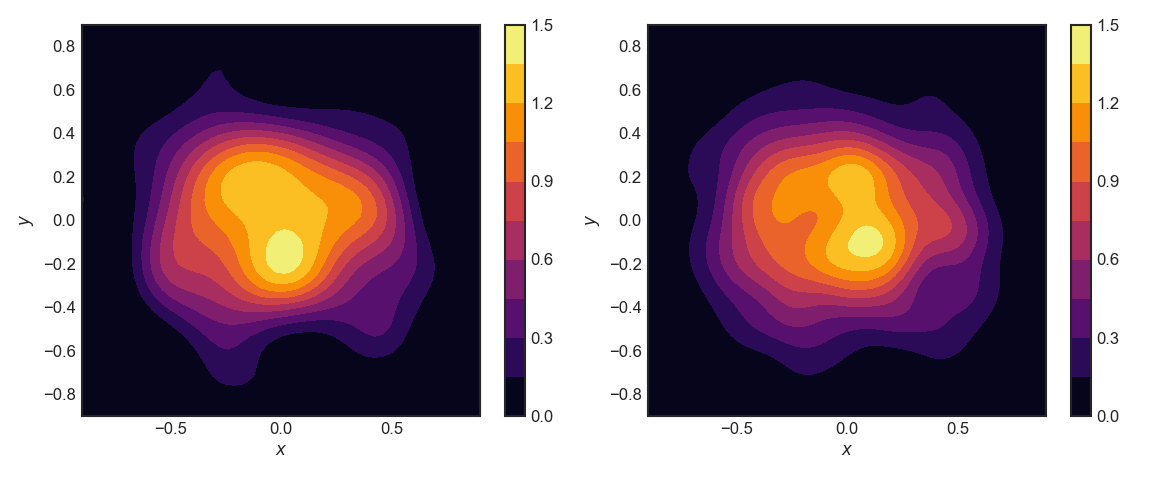

In [75]:
x_grid = np.linspace(-0.9, 0.90, 50)
y_grid = np.linspace(-0.9, 0.90, 50)
x_grid, y_grid = np.meshgrid(x_grid, y_grid)
phi_ijn_grid = npl.legvander2d(x_grid.ravel(), y_grid.ravel(), (I, J)).T / norm.ravel()[:, np.newaxis]
p = np.square(res.dot(phi_ijn_grid)).reshape((50, 50))

fig, (lax, kax) = plt.subplots(1, 2, figsize=(9.7, 4))
lax.set(xlabel=r'$x$', ylabel=r'$y$')
contour = lax.contourf(x_grid, y_grid, p, 9, cmap='inferno')
cbar = plt.colorbar(contour, ax=lax)
sbn.kdeplot(x, y, shade=True, gridsize=250, bw=(0.1, 0.1), ax=kax, cmap='inferno', cbar=True)
kax.set(xlabel=r'$x$', ylabel=r'$y$', xlim=(-0.9, 0.9), ylim=(-0.9, 0.9))
fig.tight_layout()

## Density Gradient

<IPython.core.display.Javascript object>


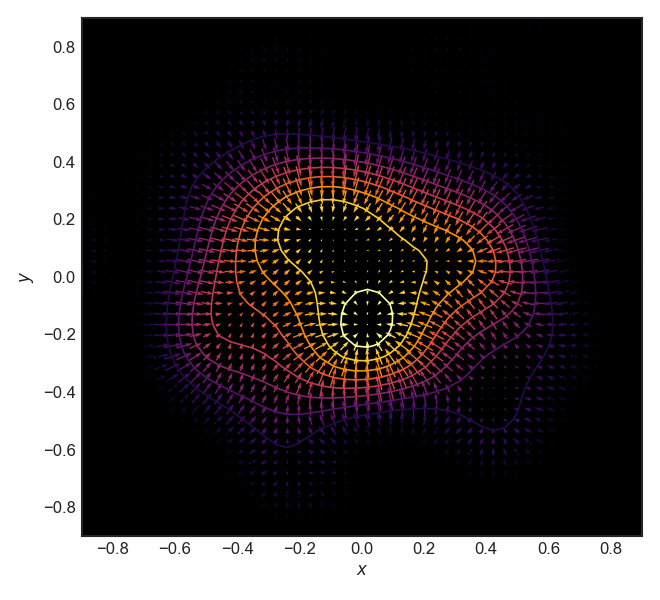

In [76]:
coeffs_of_grad_x = npl.legder(res_direct.x.reshape((I+1, J+1))/norm, axis=0)
coeffs_of_grad_y = npl.legder(res_direct.x.reshape((I+1, J+1))/norm, axis=1)

grad_x = 2*(npl.legval2d(x_grid, y_grid, res.reshape((I+1, J+1))/norm)*
            npl.legval2d(x_grid, y_grid, coeffs_of_grad_x))
grad_y = 2*(npl.legval2d(x_grid, y_grid, res.reshape((I+1, J+1))/norm)*
            npl.legval2d(x_grid, y_grid, coeffs_of_grad_y))

fig, ax = plt.subplots(figsize=(5.5, 5),)
ax.quiver(x_grid, y_grid, grad_x, grad_y, p, angles='xy', pivot='middle', cmap='inferno')
ax.contour(x_grid, y_grid, p, 9, cmap='inferno', linewidths=1.0)
ax.set(xlabel=r'$x$', ylabel=r'$y$', xlim=(-0.9, 0.9), ylim=(-0.9, 0.9), facecolor='k')
fig.tight_layout()